In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("/home/vmeshchaninov/DiffusionTextGeneration/")

In [3]:
import torch
import numpy as np
import pandas as pd
import ml_collections
import matplotlib.pyplot as plt
from collections import defaultdict

from tqdm import tqdm
from torch.utils.data import DataLoader
from diffusion_holder import DiffusionRunner
from transformers import BertConfig, BertTokenizerFast

from data.create_dataset import create_wikipedia_dataset, create_rocstory_dataset, create_glue_unsupervised_dataset
from data.preprocessing import text_preprocessor, unsupervised_preprocessor, supervised_preprocessor
from utils.util import dict_to_tensors, masked_mean, masked_std, set_seed, dict_to_cuda
from utils.ema_model import ExponentialMovingAverage

In [4]:
with torch.no_grad():    
    losses_eps = []
    outputs_eps = []
    
    for t in tqdm(range(0, diffusion.diff_eq_solver.sde.N)):
        t = t * 1. / diffusion.diff_eq_solver.sde.N
        vec_t = t * torch.ones(batch_size, device="cuda:0")
        marg_forward = diffusion.sde.marginal_forward(embs, vec_t)
        x_t = marg_forward['x_t']
        noise = marg_forward['noise']
        
        scores = diffusion.sde.calc_score(diffusion.ddp_score_estimator, x_t, vec_t)
        eps_theta = scores.pop("eps_theta")
        
        loss = diffusion.mse_loss(eps_theta, noise, mask)
        losses_eps.append(loss.item())
        outputs_eps.append(eps_theta.detach().cpu())

NameError: name 'diffusion' is not defined

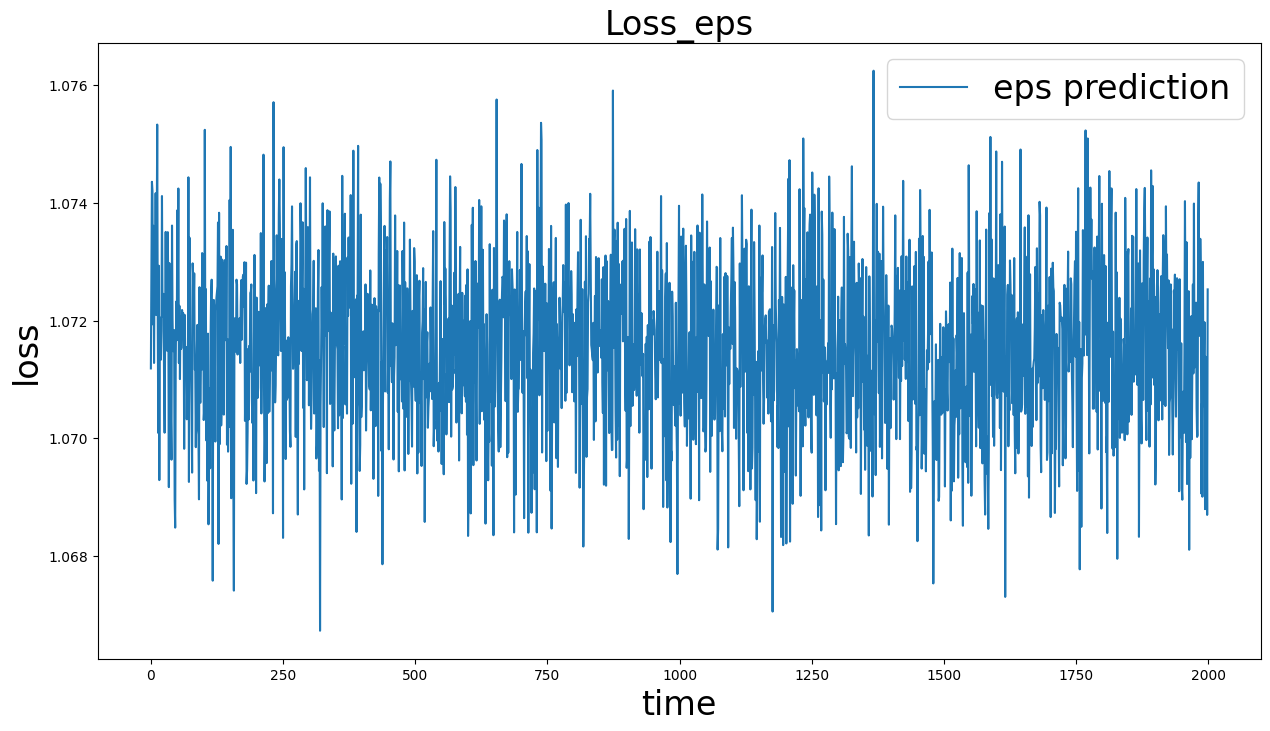

In [113]:
plt.figure(figsize=(15, 8))
plt.xlabel('time', fontsize=24)
plt.ylabel('loss', fontsize=24)
plt.title("Loss_eps", fontsize=24)

plt.plot(losses_eps, label="eps prediction")

plt.legend(fontsize=24)
plt.show()

In [26]:
outputs_eps = torch.stack(outputs_eps)

In [28]:
torch.mean(torch.std(outputs_eps, dim=0))

tensor(1.3341e-11)

То есть вывод один и тот же для всех времен, проверим теперь, различается ли вывод для разных объектов 

In [41]:
result["eps_theta"][:, 0, 0]

tensor([-7.3866e-05, -7.3866e-05, -7.3866e-05, -7.3866e-05, -7.3866e-05,
        -7.3866e-05, -7.3866e-05, -7.3866e-05, -7.3866e-05, -7.3866e-05,
        -7.3866e-05, -7.3866e-05, -7.3866e-05, -7.3866e-05, -7.3866e-05,
        -7.3866e-05, -7.3866e-05, -7.3866e-05, -7.3866e-05, -7.3866e-05,
        -7.3866e-05, -7.3866e-05, -7.3866e-05, -7.3866e-05, -7.3866e-05,
        -7.3866e-05, -7.3866e-05, -7.3866e-05, -7.3866e-05, -7.3866e-05,
        -7.3866e-05, -7.3866e-05], device='cuda:0', grad_fn=<SelectBackward0>)

**Вывод:** сеть предсказывает константу, это тоже дает лосс = 1

In [4]:
def create_config():
    config = ml_collections.ConfigDict()

    training = config.training = ml_collections.ConfigDict()
    training.ode_sampling = False
    training.checkpoints_folder = '../checkpoints'
    config.checkpoints_prefix = "rocstory--encodings-prediction=x_0-loss=L_x_0-enc=base-bert=base-kl_cf=0.0-seq_len=32-clipgrad=0.2-lr=0.0002-min_lr=0.0002-new_net_v1.0_100000_"
    sde = config.sde = ml_collections.ConfigDict()
    sde.typename = 'vp-sde'
    sde.solver = 'euler'
    sde.N = 2000
    sde.beta_min = 0.1
    sde.beta_max = 20
    sde.ode_sampling = False

    model = config.model = ml_collections.ConfigDict()
    model.ema_rate = 0.9999
    model.enc_type = "base"
    model.embeddings_type = "encodings"
    model.dif_enc_type = "base"
    model.prediction = "x_0"
    model.dataset = "rocstory"

    data = config.data = ml_collections.ConfigDict()
    data.config_path = "/home/vmeshchaninov/DiffusionTextGeneration/data/config.json"
    data.max_sequence_len = 32

    config.device = 'cuda:0'
    config.ddp = False
    config.seed = 0
    config.bert_config = None
    return config

In [5]:
config = create_config()
config.bert_config = BertConfig.from_pretrained("bert-base-uncased")

seed = config.seed
set_seed(seed)

diffusion = DiffusionRunner(config, latent_mode="encodings", eval=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
max_sequence_len = 32
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
dataset_roc = create_rocstory_dataset(split="validation", tokenizer=tokenizer, max_sequence_len=max_sequence_len)

In [7]:
batch_size = 32
loader = DataLoader(
            dataset_roc,
            batch_size=batch_size,
            num_workers=1,
            shuffle=False,
        )


for X in loader:
    break
X = dict_to_cuda(X)

In [8]:
embs = diffusion.sampler_emb({key:X[key].cuda() for key in ["input_ids", "attention_mask"]})
mask = X["attention_mask"]
torch.mean(masked_mean(embs, mask)), torch.mean(masked_std(embs, mask))

(tensor(0.0004, device='cuda:0'), tensor(0.9968, device='cuda:0'))

In [9]:
with torch.no_grad():    
    losses_x_0 = []
    outputs_x_0 = []
    
    for t in tqdm(range(0, diffusion.diff_eq_solver.sde.N)):
        t = t * 1. / diffusion.diff_eq_solver.sde.N
        vec_t = t * torch.ones(batch_size, device="cuda:0")
        marg_forward = diffusion.sde.marginal_forward(embs, vec_t)
        x_t = marg_forward['x_t']
        noise = marg_forward['noise']
        
        scores = diffusion.sde.calc_score(diffusion.ddp_score_estimator, x_t, vec_t)
        x_0 = scores.pop("x_0")
        
        loss = diffusion.mse_loss(x_0, embs, mask)
        losses_x_0.append(loss.item())
        outputs_x_0.append(x_0.detach().cpu())

100%|██████████| 2000/2000 [00:35<00:00, 57.00it/s]


In [39]:
t = 1999 * 1. / diffusion.diff_eq_solver.sde.N
vec_t = t * torch.ones(batch_size, device="cuda:0")

x_0 = embs
params = diffusion.sde.marginal_params_tensor(x_t, vec_t)
alpha, std = params['alpha'], params['std']
alpha = torch.zeros_like(alpha)
print(alpha[0, 0, 0], std[0, 0, 0])

x_t = alpha * x_0 + torch.randn_like(x_0) * std

scores = diffusion.sde.calc_score(diffusion.ddp_score_estimator, x_t, vec_t)
x_0 = scores.pop("x_0")

loss = diffusion.mse_loss(x_0, embs, mask)
loss.item()

tensor(0., device='cuda:0') tensor(1.0000, device='cuda:0')


0.9255450963973999

In [40]:
torch.mean(masked_std(embs, mask))

tensor(0.9968, device='cuda:0')

In [41]:
torch.mean(masked_std(x_0, mask))

tensor(0.2595, device='cuda:0', grad_fn=<MeanBackward0>)

In [42]:
torch.mean(masked_std(x_t, mask))

tensor(1.0004, device='cuda:0')

In [78]:
# dim = 0
# idx = torch.randperm(x_0.shape[dim])
# x_0_shuffled = x_0[idx]

x_0_shuffled = x_0
dim = 1
idx = torch.randperm(x_0_shuffled.shape[dim])
x_0_shuffled = x_0_shuffled[:, idx]

In [79]:
torch.mean((x_0 - embs) ** 2).item(), torch.mean((x_0_shuffled - embs) ** 2).item(), torch.mean((x_0_shuffled - x_0) ** 2).item()

(0.9255450963973999, 1.0885978937149048, 0.16919295489788055)

In [73]:
torch.mean(x_0, dim=[0])

tensor([[-0.1821,  0.0300, -0.7709,  ..., -0.1417,  0.7541,  0.9105],
        [ 0.2818, -0.4196, -0.4937,  ...,  0.0671,  1.5233,  0.2807],
        [ 0.1676, -0.2992, -0.2383,  ...,  0.1601,  0.3721,  0.0462],
        ...,
        [ 0.1836, -0.2739,  0.0132,  ..., -0.0645, -0.1195, -0.1736],
        [-0.2787, -1.1599, -0.8750,  ...,  1.2040,  0.2438, -0.4433],
        [-0.1196,  0.4460,  0.2215,  ...,  0.7801, -0.3411, -0.9694]],
       device='cuda:0', grad_fn=<MeanBackward1>)

In [91]:
mask_2 = torch.ones_like(mask)
loss = diffusion.mse_loss(x_0, embs, mask_2).item()
print(f"{loss:0.5f}")
for i in range(32):
    mask_2[:, i] = 0
    loss = diffusion.mse_loss(x_0, embs, mask_2).item()
    print(i, f"{loss:0.5f}")


0.92555
0 0.94497
1 0.94996
2 0.95275
3 0.95346
4 0.95413
5 0.95414
6 0.95320
7 0.95012
8 0.94809
9 0.94772
10 0.94854
11 0.94955
12 0.95047
13 0.95099
14 0.95186
15 0.94987
16 0.94665
17 0.94382
18 0.94106
19 0.94013
20 0.93627
21 0.93618
22 0.93179
23 0.92467
24 0.91532
25 0.91191
26 0.88469
27 0.85289
28 0.77293
29 0.65279
30 0.63074
31 nan


In [103]:
mask_2 = torch.ones_like(mask)

mask_2[:, [0, 1, 31, 30]] = 0

In [104]:
diffusion.mse_loss(x_0, embs, mask_2)

tensor(0.9712, device='cuda:0', grad_fn=<DivBackward0>)

In [82]:
for i in X["input_ids"]:
    print(i[:10].detach().cpu().numpy().tolist())

[101, 10829, 2018, 23008, 2005, 1996, 2599, 1999, 1996, 2082]
[101, 1996, 23655, 2545, 2020, 2183, 2006, 1037, 2492, 4440]
[101, 15731, 1998, 2014, 2155, 2165, 1037, 4440, 2000, 4958]
[101, 1996, 2611, 2001, 6015, 2000, 2175, 2648, 1012, 2014]
[101, 5553, 1005, 1055, 10437, 3631, 1012, 5553, 2787, 2000]
[101, 2023, 2095, 1045, 3427, 1996, 6452, 24654, 2243, 5049]
[101, 2009, 2001, 7482, 1005, 1055, 2034, 2154, 1997, 11793]
[101, 23682, 1998, 3520, 2018, 2673, 2027, 2734, 2000, 2191]
[101, 2577, 2001, 2012, 1996, 3309, 2197, 2305, 1012, 2002]
[101, 2028, 5027, 1010, 1045, 2292, 2026, 3899, 1010, 6090]
[101, 22905, 2018, 2000, 2191, 1037, 9231, 11484, 4950, 2005]
[101, 6498, 2001, 7501, 1012, 2002, 2787, 2000, 2191, 24799]
[101, 10680, 2038, 2371, 14777, 2008, 2009, 2038, 2042, 2200]
[101, 1996, 3044, 2155, 2253, 2000, 1037, 28305, 1012, 1996]
[101, 1996, 10533, 2409, 10872, 2000, 2191, 2469, 1996, 2918]
[101, 2057, 2018, 4596, 1999, 6613, 3892, 1012, 1996, 2443]
[101, 9342, 2179, 2041, 

In [24]:
torch.mean(masked_mean(x_0, mask))

tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>)

In [27]:
torch.mean((x_0 - embs) ** 2)

tensor(0.9226, device='cuda:0', grad_fn=<MeanBackward0>)

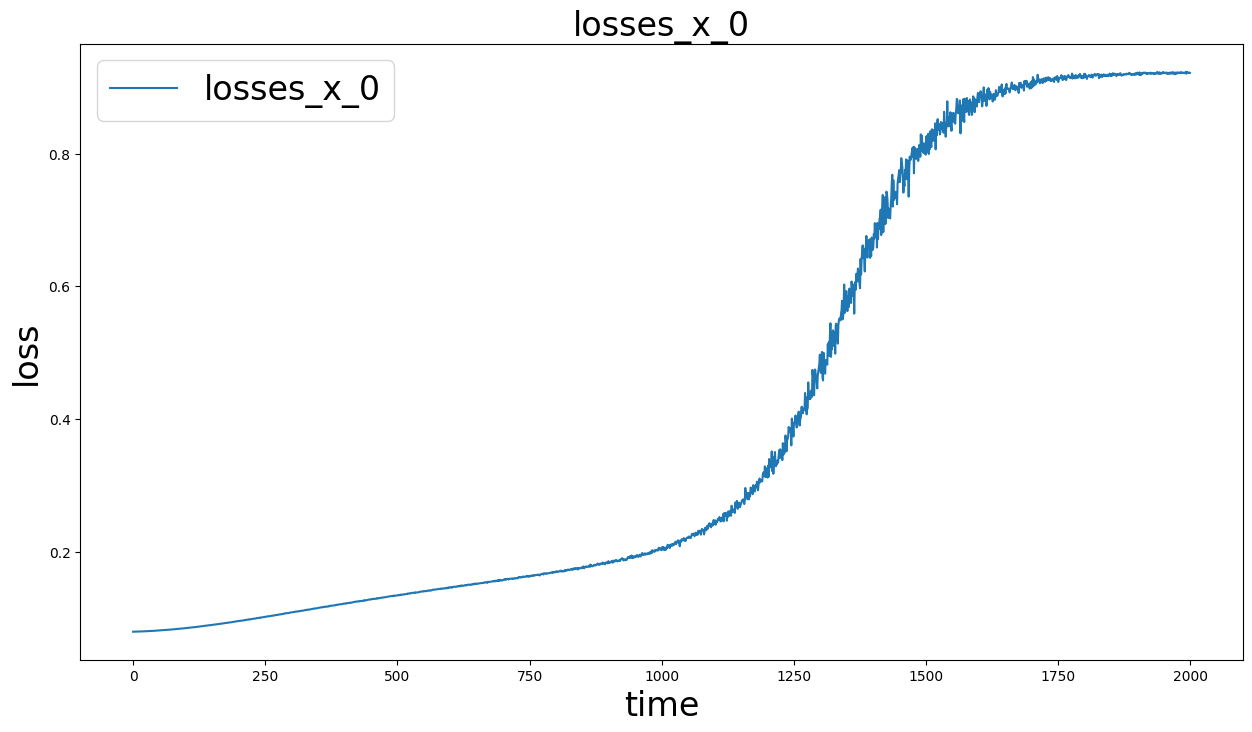

In [11]:
plt.figure(figsize=(15, 8))
plt.xlabel('time', fontsize=24)
plt.ylabel('loss', fontsize=24)
plt.title("losses_x_0", fontsize=24)

plt.plot(losses_x_0, label="losses_x_0")

plt.legend(fontsize=24)
plt.show()

In [42]:
outputs_x_0 = torch.stack(outputs_x_0)

In [44]:
torch.mean(torch.std(outputs_x_0, dim=0))

tensor(0.3935)

In [62]:
torch.mean(torch.std(outputs_x_0[1500], dim=[1, 2]))

tensor(0.3273)

In [48]:
outputs_x_0.shape

torch.Size([2000, 32, 32, 768])

In [12]:
sum([torch.norm(t).item() for t in diffusion.score_estimator.parameters()])

3659.6098044219834

In [6]:
model = diffusion.score_estimator

In [12]:
for name, par in model.named_parameters():
    print(par[0].weight.grad)
    break

AttributeError: 'Tensor' object has no attribute 'weight'

In [15]:
par.grad

In [24]:
max_sequence_len = 32
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
dataset_roc = create_rocstory_dataset(split="validation", tokenizer=tokenizer, max_sequence_len=max_sequence_len)

In [26]:
loader = iter(DataLoader(
            dataset_roc,
            batch_size=1024 * 4,
            num_workers=1,
            shuffle=False,
        ))

In [27]:
t = next(loader)
res = tokenizer.batch_decode(t["input_ids"])

In [32]:
with open("../generated_texts/rocstory_texts.txt", "w") as file:
    for t in res:
        print(t, file=file)

tensor([  101,  1996, 23655,  2545,  2020,  2183,  2006,  1037,  2492,  4440,
         1012,  2037,  5089,  2165,  2068,  2000,  1996,  2543,  2276,  1012,
         2027,  5720,  2000,  1996, 21767,  1012,  2027,  2387,  1996,  2543,
         4744,   102])

In [4]:
from transformers import BertLMHeadModel

In [26]:
model = BertLMHeadModel.from_pretrained("bert-base-uncased").cuda().eval()

If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
max_sequence_len = 32
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
dataset_roc = create_rocstory_dataset(split="validation", tokenizer=tokenizer, max_sequence_len=max_sequence_len)

In [28]:
loader = DataLoader(
            dataset_roc,
            batch_size=512,
            num_workers=1,
            shuffle=False,
        )

In [29]:
with torch.no_grad():
    result_text = []
    for t in tqdm(loader):
        t = dict_to_cuda(t)
        tokens = model(**t).logits.argmax(dim=-1)
        text = tokenizer.batch_decode(tokens)
        result_text += text

100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


In [30]:
with open("../generated_texts/bert_rocstory_texts.txt", "w") as file:
    for t in result_text:
        print(t, file=file)

# Эксперимент 3: Анализ слоев сети

In [153]:
def create_config():
    config = ml_collections.ConfigDict()
    optim = config.optim = ml_collections.ConfigDict()
    optim.grad_clip_norm = 1.
    optim.linear_warmup = 5000
    optim.lr = 2e-4
    optim.min_lr = 2e-4
    optim.warmup_lr = 1e-6
    optim.weight_decay = 0

    training = config.training = ml_collections.ConfigDict()
    training.ode_sampling = False
    training.checkpoints_folder = '../checkpoints'
    training.training_iters = 1_000_000
    training.checkpoint_freq = 200_000
    training.eval_freq = 10_000
    training.batch_size = 256
    
    config.checkpoints_prefix = ""
    sde = config.sde = ml_collections.ConfigDict()
    sde.typename = 'vp-sde'
    sde.solver = 'euler'
    sde.N = 2000
    sde.beta_min = 0.1
    sde.beta_max = 20
    sde.ode_sampling = False

    model = config.model = ml_collections.ConfigDict()
    model.ema_rate = 0.9999
    model.enc_type = "base"
    model.embeddings_type = "encodings"
    model.dif_enc_type = "base"
    model.prediction = "eps"
    model.dataset = "wikipedia"

    data = config.data = ml_collections.ConfigDict()
    data.config_path = "/home/vmeshchaninov/DiffusionTextGeneration/data/config.json"
    data.max_sequence_len = 64

    config.lin_input = False
    config.device = 'cuda:0'
    config.ddp = False
    config.seed = 1
    config.bert_config = None
    
    refresh = config.refresh = ml_collections.ConfigDict()
    refresh.true = True
    refresh.prefix = "../checkpoints/wikipedia--encodings-prediction=eps-loss=L_eps-enc=base-bert=base-kl_cf=0.0-seq_len=64-clipgrad=1.0-lr=0.0002-min_lr=0.0002-lin_input=False-seed=0-wd=0.0-gradient_exploding-old_net_79600_.pth"
    return config

In [154]:
config = create_config()
config.bert_config = BertConfig.from_pretrained("bert-base-uncased")

seed = config.seed
set_seed(seed)

diffusion = DiffusionRunner(config, latent_mode="encodings", eval=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [194]:
for name, par in diffusion.score_estimator.named_parameters():
    par.requires_grad = True

In [195]:
diffusion.set_optimizer()
diffusion.set_scheduler()
diffusion.step = 0
diffusion.ema = ExponentialMovingAverage(diffusion.score_estimator.parameters(), diffusion.config.model.ema_rate)
diffusion.refresh_checkpoint()

diffusion.grad_expl_dict = defaultdict(list)
diffusion.weight_expl_dict = defaultdict(list)

Checkpoint refreshed ../checkpoints/wikipedia--encodings-prediction=eps-loss=L_eps-enc=base-bert=base-kl_cf=0.0-seq_len=64-clipgrad=1.0-lr=0.0002-min_lr=0.0002-lin_input=False-seed=0-wd=0.0-gradient_exploding-old_net_79600_.pth


In [131]:
def req_grad_false(par, momentum_zero):
    par.requires_grad = False
    if momentum_zero:
        d = diffusion.optimizer.state[par]
        d["exp_avg"] = torch.zeros_like(d["exp_avg"])

### Эксперимент 1

In [132]:
momentum_zero = True

In [176]:
for name, par in diffusion.score_estimator.input_up_proj.named_parameters():
    req_grad_false(par, momentum_zero=momentum_zero)

In [177]:
for name, par in diffusion.score_estimator.time_emb.named_parameters():
    req_grad_false(par, momentum_zero=momentum_zero)

In [178]:
for name, par in diffusion.score_estimator.position_embeddings.named_parameters():
    req_grad_false(par, momentum_zero=momentum_zero)

In [179]:
for name, par in diffusion.score_estimator.output_down_proj.named_parameters():
    req_grad_false(par, momentum_zero=momentum_zero)

In [180]:
for name, par in diffusion.score_estimator.LayerNorm.named_parameters():
    req_grad_false(par, momentum_zero=momentum_zero)

In [190]:
for name, par in diffusion.score_estimator.encoder.named_parameters():
    req_grad_false(par, momentum_zero=momentum_zero)

### ...

In [137]:
def run_batch(diffusion, n):
    batch = torch.load(f"../logs/batch-{n}.pt", map_location="cuda:0")
    time = torch.load(f"../logs/time-{n}.pt", map_location="cuda:0")
    x_t = torch.load(f"../logs/x_t-{n}.pt", map_location="cuda:0")
    noise = torch.load(f"../logs/noise-{n}.pt", map_location="cuda:0")
    
    #t = torch.ones(x_t.shape[0], device="cuda:0") * 0.95
    
    t = time.cuda()

    X = dict_to_cuda(batch)
    scores = diffusion.sde.calc_score(diffusion.score_estimator, x_t, t, mask=X["attention_mask"])
    eps_theta = scores['eps_theta']
    mask = X["attention_mask"]

    loss_eps = diffusion.mse_loss(noise, eps_theta, mask)
        
    diffusion.optimizer.zero_grad()
    loss_eps.backward()
    
    grad_norm = torch.nn.utils.clip_grad_norm_(
                diffusion.score_estimator.parameters(),
                max_norm=1.
            )
    
    # norm = torch.sum((noise * mask[..., None]) ** 2) / torch.sum(mask) / 768
    # print(norm)
    
    return loss_eps, grad_norm, eps_theta, mask

In [193]:
set_seed(0)
for n in range(79600, 79630):
    loss_eps, grad_norm, eps_theta, mask = run_batch(diffusion, n)
    
    name = "steps"
    diffusion.grad_expl_dict[name].append(n)

    for name, par in diffusion.score_estimator.named_parameters():
        diffusion.grad_expl_dict[name].append(torch.norm(par.grad).item())
        diffusion.weight_expl_dict[name].append(torch.norm(par.data).item())
    
    diffusion.optimizer.step()
    diffusion.scheduler.step_update(diffusion.step)
    
    norm = torch.sum((eps_theta * mask[..., None]) ** 2) / torch.sum(mask) / 768
    
    print(f"iter: {n}, loss: {loss_eps.item():0.4f}, grad_norm: {grad_norm.item():0.4f}, eps_theta: {norm.item():0.4f}")

iter: 79600, loss: 0.2835, grad_norm: 0.0472, eps_theta: 0.7153
iter: 79601, loss: 0.3143, grad_norm: 0.0532, eps_theta: 0.6891
iter: 79602, loss: 0.2829, grad_norm: 0.0426, eps_theta: 0.7219
iter: 79603, loss: 0.2856, grad_norm: 0.0449, eps_theta: 0.7153
iter: 79604, loss: 0.3088, grad_norm: 0.0526, eps_theta: 0.6924
iter: 79605, loss: 0.3221, grad_norm: 0.0508, eps_theta: 0.6809
iter: 79606, loss: 0.2830, grad_norm: 0.0418, eps_theta: 0.7192
iter: 79607, loss: 0.2679, grad_norm: 0.0410, eps_theta: 0.7328
iter: 79608, loss: 0.2975, grad_norm: 0.0462, eps_theta: 0.7028
iter: 79609, loss: 0.3185, grad_norm: 0.0493, eps_theta: 0.6802
iter: 79610, loss: 0.2790, grad_norm: 0.0403, eps_theta: 0.7184
iter: 79611, loss: 0.2990, grad_norm: 0.0494, eps_theta: 0.6985
iter: 79612, loss: 0.3105, grad_norm: 0.0502, eps_theta: 0.6871
iter: 79613, loss: 0.2902, grad_norm: 0.0435, eps_theta: 0.7068
iter: 79614, loss: 0.3054, grad_norm: 0.0457, eps_theta: 0.6931
iter: 79615, loss: 0.3009, grad_norm: 0.

In [10]:
(256 * 62 * 768) ** (1/2)

3491.374514428379

In [69]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [171]:
dataframe = pd.DataFrame.from_dict(diffusion.grad_expl_dict)
dataframe

,steps,time_emb.0.weight,time_emb.0.bias,time_emb.2.weight,time_emb.2.bias,encoder.layer.0.attention.self.query.weight,encoder.layer.0.attention.self.query.bias,encoder.layer.0.attention.self.key.weight,encoder.layer.0.attention.self.key.bias,encoder.layer.0.attention.self.value.weight,encoder.layer.0.attention.self.value.bias,encoder.layer.0.attention.output.dense.weight,encoder.layer.0.attention.output.dense.bias,encoder.layer.0.attention.output.LayerNorm.weight,encoder.layer.0.attention.output.LayerNorm.bias,encoder.layer.0.intermediate.dense.weight,encoder.layer.0.intermediate.dense.bias,encoder.layer.0.output.dense.weight,encoder.layer.0.output.dense.bias,encoder.layer.0.output.LayerNorm.weight,encoder.layer.0.output.LayerNorm.bias,encoder.layer.1.attention.self.query.weight,encoder.layer.1.attention.self.query.bias,encoder.layer.1.attention.self.key.weight,encoder.layer.1.attention.self.key.bias,encoder.layer.1.attention.self.value.weight,encoder.layer.1.attention.self.value.bias,encoder.layer.1.attention.output.dense.weight,encoder.layer.1.attention.output.dense.bias,encoder.layer.1.attention.output.LayerNorm.weight,encoder.layer.1.attention.output.LayerNorm.bias,encoder.layer.1.intermediate.dense.weight,encoder.layer.1.intermediate.dense.bias,encoder.layer.1.output.dense.weight,encoder.layer.1.output.dense.bias,encoder.layer.1.output.LayerNorm.weight,encoder.layer.1.output.LayerNorm.bias,encoder.layer.2.attention.self.query.weight,encoder.layer.2.attention.self.query.bias,encoder.layer.2.attention.self.key.weight,encoder.layer.2.attention.self.key.bias,encoder.layer.2.attention.self.value.weight,encoder.layer.2.attention.self.value.bias,encoder.layer.2.attention.output.dense.weight,encoder.layer.2.attention.output.dense.bias,encoder.layer.2.attention.output.LayerNorm.weight,encoder.layer.2.attention.output.LayerNorm.bias,encoder.layer.2.intermediate.dense.weight,encoder.layer.2.intermediate.dense.bias,encoder.layer.2.output.dense.weight,encoder.layer.2.output.dense.bias,encoder.layer.2.output.LayerNorm.weight,encoder.layer.2.output.LayerNorm.bias,encoder.layer.3.attention.self.query.weight,encoder.layer.3.attention.self.query.bias,encoder.layer.3.attention.self.key.weight,encoder.layer.3.attention.self.key.bias,encoder.layer.3.attention.self.value.weight,encoder.layer.3.attention.self.value.bias,encoder.layer.3.attention.output.dense.weight,encoder.layer.3.attention.output.dense.bias,encoder.layer.3.attention.output.LayerNorm.weight,encoder.layer.3.attention.output.LayerNorm.bias,encoder.layer.3.intermediate.dense.weight,encoder.layer.3.intermediate.dense.bias,encoder.layer.3.output.dense.weight,encoder.layer.3.output.dense.bias,encoder.layer.3.output.LayerNorm.weight,encoder.layer.3.output.LayerNorm.bias,encoder.layer.4.attention.self.query.weight,encoder.layer.4.attention.self.query.bias,encoder.layer.4.attention.self.key.weight,encoder.layer.4.attention.self.key.bias,encoder.layer.4.attention.self.value.weight,encoder.layer.4.attention.self.value.bias,encoder.layer.4.attention.output.dense.weight,encoder.layer.4.attention.output.dense.bias,encoder.layer.4.attention.output.LayerNorm.weight,encoder.layer.4.attention.output.LayerNorm.bias,encoder.layer.4.intermediate.dense.weight,encoder.layer.4.intermediate.dense.bias,encoder.layer.4.output.dense.weight,encoder.layer.4.output.dense.bias,encoder.layer.4.output.LayerNorm.weight,encoder.layer.4.output.LayerNorm.bias,encoder.layer.5.attention.self.query.weight,encoder.layer.5.attention.self.query.bias,encoder.layer.5.attention.self.key.weight,encoder.layer.5.attention.self.key.bias,encoder.layer.5.attention.self.value.weight,encoder.layer.5.attention.self.value.bias,encoder.layer.5.attention.output.dense.weight,encoder.layer.5.attention.output.dense.bias,encoder.layer.5.attention.output.LayerNorm.weight,encoder.layer.5.attention.output.LayerNorm.bias,encoder.layer.5.intermediate.dense.weight,encoder.layer.5.intermediate.dense.bias,encoder.layer.5.output.dense.weight,encod

In [172]:
dataframe1 = pd.DataFrame.from_dict(diffusion.grad_expl_dict)
dataframe1

,steps,time_emb.0.weight,time_emb.0.bias,time_emb.2.weight,time_emb.2.bias,encoder.layer.0.attention.self.query.weight,encoder.layer.0.attention.self.query.bias,encoder.layer.0.attention.self.key.weight,encoder.layer.0.attention.self.key.bias,encoder.layer.0.attention.self.value.weight,encoder.layer.0.attention.self.value.bias,encoder.layer.0.attention.output.dense.weight,encoder.layer.0.attention.output.dense.bias,encoder.layer.0.attention.output.LayerNorm.weight,encoder.layer.0.attention.output.LayerNorm.bias,encoder.layer.0.intermediate.dense.weight,encoder.layer.0.intermediate.dense.bias,encoder.layer.0.output.dense.weight,encoder.layer.0.output.dense.bias,encoder.layer.0.output.LayerNorm.weight,encoder.layer.0.output.LayerNorm.bias,encoder.layer.1.attention.self.query.weight,encoder.layer.1.attention.self.query.bias,encoder.layer.1.attention.self.key.weight,encoder.layer.1.attention.self.key.bias,encoder.layer.1.attention.self.value.weight,encoder.layer.1.attention.self.value.bias,encoder.layer.1.attention.output.dense.weight,encoder.layer.1.attention.output.dense.bias,encoder.layer.1.attention.output.LayerNorm.weight,encoder.layer.1.attention.output.LayerNorm.bias,encoder.layer.1.intermediate.dense.weight,encoder.layer.1.intermediate.dense.bias,encoder.layer.1.output.dense.weight,encoder.layer.1.output.dense.bias,encoder.layer.1.output.LayerNorm.weight,encoder.layer.1.output.LayerNorm.bias,encoder.layer.2.attention.self.query.weight,encoder.layer.2.attention.self.query.bias,encoder.layer.2.attention.self.key.weight,encoder.layer.2.attention.self.key.bias,encoder.layer.2.attention.self.value.weight,encoder.layer.2.attention.self.value.bias,encoder.layer.2.attention.output.dense.weight,encoder.layer.2.attention.output.dense.bias,encoder.layer.2.attention.output.LayerNorm.weight,encoder.layer.2.attention.output.LayerNorm.bias,encoder.layer.2.intermediate.dense.weight,encoder.layer.2.intermediate.dense.bias,encoder.layer.2.output.dense.weight,encoder.layer.2.output.dense.bias,encoder.layer.2.output.LayerNorm.weight,encoder.layer.2.output.LayerNorm.bias,encoder.layer.3.attention.self.query.weight,encoder.layer.3.attention.self.query.bias,encoder.layer.3.attention.self.key.weight,encoder.layer.3.attention.self.key.bias,encoder.layer.3.attention.self.value.weight,encoder.layer.3.attention.self.value.bias,encoder.layer.3.attention.output.dense.weight,encoder.layer.3.attention.output.dense.bias,encoder.layer.3.attention.output.LayerNorm.weight,encoder.layer.3.attention.output.LayerNorm.bias,encoder.layer.3.intermediate.dense.weight,encoder.layer.3.intermediate.dense.bias,encoder.layer.3.output.dense.weight,encoder.layer.3.output.dense.bias,encoder.layer.3.output.LayerNorm.weight,encoder.layer.3.output.LayerNorm.bias,encoder.layer.4.attention.self.query.weight,encoder.layer.4.attention.self.query.bias,encoder.layer.4.attention.self.key.weight,encoder.layer.4.attention.self.key.bias,encoder.layer.4.attention.self.value.weight,encoder.layer.4.attention.self.value.bias,encoder.layer.4.attention.output.dense.weight,encoder.layer.4.attention.output.dense.bias,encoder.layer.4.attention.output.LayerNorm.weight,encoder.layer.4.attention.output.LayerNorm.bias,encoder.layer.4.intermediate.dense.weight,encoder.layer.4.intermediate.dense.bias,encoder.layer.4.output.dense.weight,encoder.layer.4.output.dense.bias,encoder.layer.4.output.LayerNorm.weight,encoder.layer.4.output.LayerNorm.bias,encoder.layer.5.attention.self.query.weight,encoder.layer.5.attention.self.query.bias,encoder.layer.5.attention.self.key.weight,encoder.layer.5.attention.self.key.bias,encoder.layer.5.attention.self.value.weight,encoder.layer.5.attention.self.value.bias,encoder.layer.5.attention.output.dense.weight,encoder.layer.5.attention.output.dense.bias,encoder.layer.5.attention.output.LayerNorm.weight,encoder.layer.5.attention.output.LayerNorm.bias,encoder.layer.5.intermediate.dense.weight,encoder.layer.5.intermediate.dense.bias,encoder.layer.5.output.dense.weight,encod

In [173]:
pd.DataFrame.from_dict(diffusion.weight_expl_dict)

,time_emb.0.weight,time_emb.0.bias,time_emb.2.weight,time_emb.2.bias,encoder.layer.0.attention.self.query.weight,encoder.layer.0.attention.self.query.bias,encoder.layer.0.attention.self.key.weight,encoder.layer.0.attention.self.key.bias,encoder.layer.0.attention.self.value.weight,encoder.layer.0.attention.self.value.bias,encoder.layer.0.attention.output.dense.weight,encoder.layer.0.attention.output.dense.bias,encoder.layer.0.attention.output.LayerNorm.weight,encoder.layer.0.attention.output.LayerNorm.bias,encoder.layer.0.intermediate.dense.weight,encoder.layer.0.intermediate.dense.bias,encoder.layer.0.output.dense.weight,encoder.layer.0.output.dense.bias,encoder.layer.0.output.LayerNorm.weight,encoder.layer.0.output.LayerNorm.bias,encoder.layer.1.attention.self.query.weight,encoder.layer.1.attention.self.query.bias,encoder.layer.1.attention.self.key.weight,encoder.layer.1.attention.self.key.bias,encoder.layer.1.attention.self.value.weight,encoder.layer.1.attention.self.value.bias,encoder.layer.1.attention.output.dense.weight,encoder.layer.1.attention.output.dense.bias,encoder.layer.1.attention.output.LayerNorm.weight,encoder.layer.1.attention.output.LayerNorm.bias,encoder.layer.1.intermediate.dense.weight,encoder.layer.1.intermediate.dense.bias,encoder.layer.1.output.dense.weight,encoder.layer.1.output.dense.bias,encoder.layer.1.output.LayerNorm.weight,encoder.layer.1.output.LayerNorm.bias,encoder.layer.2.attention.self.query.weight,encoder.layer.2.attention.self.query.bias,encoder.layer.2.attention.self.key.weight,encoder.layer.2.attention.self.key.bias,encoder.layer.2.attention.self.value.weight,encoder.layer.2.attention.self.value.bias,encoder.layer.2.attention.output.dense.weight,encoder.layer.2.attention.output.dense.bias,encoder.layer.2.attention.output.LayerNorm.weight,encoder.layer.2.attention.output.LayerNorm.bias,encoder.layer.2.intermediate.dense.weight,encoder.layer.2.intermediate.dense.bias,encoder.layer.2.output.dense.weight,encoder.layer.2.output.dense.bias,encoder.layer.2.output.LayerNorm.weight,encoder.layer.2.output.LayerNorm.bias,encoder.layer.3.attention.self.query.weight,encoder.layer.3.attention.self.query.bias,encoder.layer.3.attention.self.key.weight,encoder.layer.3.attention.self.key.bias,encoder.layer.3.attention.self.value.weight,encoder.layer.3.attention.self.value.bias,encoder.layer.3.attention.output.dense.weight,encoder.layer.3.attention.output.dense.bias,encoder.layer.3.attention.output.LayerNorm.weight,encoder.layer.3.attention.output.LayerNorm.bias,encoder.layer.3.intermediate.dense.weight,encoder.layer.3.intermediate.dense.bias,encoder.layer.3.output.dense.weight,encoder.layer.3.output.dense.bias,encoder.layer.3.output.LayerNorm.weight,encoder.layer.3.output.LayerNorm.bias,encoder.layer.4.attention.self.query.weight,encoder.layer.4.attention.self.query.bias,encoder.layer.4.attention.self.key.weight,encoder.layer.4.attention.self.key.bias,encoder.layer.4.attention.self.value.weight,encoder.layer.4.attention.self.value.bias,encoder.layer.4.attention.output.dense.weight,encoder.layer.4.attention.output.dense.bias,encoder.layer.4.attention.output.LayerNorm.weight,encoder.layer.4.attention.output.LayerNorm.bias,encoder.layer.4.intermediate.dense.weight,encoder.layer.4.intermediate.dense.bias,encoder.layer.4.output.dense.weight,encoder.layer.4.output.dense.bias,encoder.layer.4.output.LayerNorm.weight,encoder.layer.4.output.LayerNorm.bias,encoder.layer.5.attention.self.query.weight,encoder.layer.5.attention.self.query.bias,encoder.layer.5.attention.self.key.weight,encoder.layer.5.attention.self.key.bias,encoder.layer.5.attention.self.value.weight,encoder.layer.5.attention.self.value.bias,encoder.layer.5.attention.output.dense.weight,encoder.layer.5.attention.output.dense.bias,encoder.layer.5.attention.output.LayerNorm.weight,encoder.layer.5.attention.output.LayerNorm.bias,encoder.layer.5.intermediate.dense.weight,encoder.layer.5.intermediate.dense.bias,encoder.layer.5.output.dense.weight,encoder.lay

In [91]:
data_weights = pd.DataFrame.from_dict(diffusion.weight_expl_dict)

In [93]:
(data_weights.iloc[18] - data_weights.iloc[11]).abs().sort_values(ascending=False)[:15]

encoder.time_layers.0.weight                             0.103537
encoder.second_layers.5.attention.output.dense.weight    0.090316
encoder.time_layers.2.weight                             0.051043
encoder.second_layers.3.intermediate.dense.weight        0.046024
encoder.first_layers.0.attention.self.query.weight       0.041548
encoder.first_layers.0.attention.self.key.weight         0.041004
encoder.second_layers.2.intermediate.dense.weight        0.037922
encoder.first_layers.1.attention.self.query.weight       0.037420
encoder.first_layers.1.intermediate.dense.weight         0.037285
encoder.first_layers.1.attention.self.key.weight         0.036837
encoder.second_layers.5.attention.self.value.weight      0.036134
encoder.first_layers.1.output.dense.weight               0.035379
encoder.first_layers.2.output.dense.weight               0.034519
encoder.first_layers.3.output.dense.weight               0.034355
encoder.time_layers.3.weight                             0.034189
dtype: flo

In [94]:
(data_weights.iloc[11] - data_weights.iloc[4]).abs().sort_values(ascending=False)[:15]

output_down_proj.2.weight                             0.018723
encoder.first_layers.4.output.dense.weight            0.014225
encoder.first_layers.5.output.dense.weight            0.013924
encoder.first_layers.3.output.dense.weight            0.013287
encoder.first_layers.4.intermediate.dense.weight      0.013042
encoder.first_layers.3.intermediate.dense.weight      0.012836
encoder.first_layers.1.attention.self.query.weight    0.012720
encoder.first_layers.1.attention.self.key.weight      0.012644
encoder.second_layers.0.output.dense.weight           0.012367
encoder.first_layers.0.intermediate.dense.weight      0.011765
encoder.first_layers.5.intermediate.dense.weight      0.011608
encoder.first_layers.2.intermediate.dense.weight      0.011356
encoder.second_layers.1.output.dense.weight           0.010563
encoder.second_layers.0.intermediate.dense.weight     0.010559
encoder.second_layers.5.intermediate.dense.weight     0.010067
dtype: float64

In [185]:
it = 9
((data_weights.iloc[it + 1] - data_weights.iloc[it]) / data_weights.iloc[it]).sort_values(ascending=False)[:15]

encoder.first_layers.5.output.LayerNorm.bias               0.000571
encoder.norm_layers.9.bias                                 0.000545
encoder.second_layers.2.attention.output.LayerNorm.bias    0.000539
encoder.second_layers.5.attention.output.dense.weight      0.000519
encoder.first_layers.0.attention.self.query.bias           0.000417
encoder.first_layers.5.attention.self.query.bias           0.000395
encoder.second_layers.3.attention.output.LayerNorm.bias    0.000394
encoder.second_layers.3.output.LayerNorm.bias              0.000379
encoder.second_layers.2.output.LayerNorm.bias              0.000369
encoder.norm_layers.8.bias                                 0.000368
encoder.second_layers.0.output.LayerNorm.bias              0.000367
encoder.second_layers.1.output.LayerNorm.bias              0.000323
encoder.first_layers.1.output.dense.bias                   0.000308
encoder.first_layers.3.output.dense.bias                   0.000220
encoder.first_layers.2.attention.self.query.bias

In [187]:
it = 0
((data_weights.iloc[it + 1] - data_weights.iloc[it]) / data_weights.iloc[it]).sort_values(ascending=False)[:15]

encoder.norm_layers.10.bias                                0.001403
encoder.norm_layers.9.bias                                 0.001196
encoder.second_layers.3.attention.output.LayerNorm.bias    0.001084
encoder.second_layers.4.output.dense.bias                  0.000958
encoder.second_layers.4.output.LayerNorm.bias              0.000916
encoder.second_layers.4.attention.output.LayerNorm.bias    0.000648
encoder.norm_layers.3.bias                                 0.000615
encoder.second_layers.2.attention.output.LayerNorm.bias    0.000612
encoder.second_layers.1.attention.output.LayerNorm.bias    0.000490
encoder.norm_layers.8.bias                                 0.000483
encoder.first_layers.3.attention.output.LayerNorm.bias     0.000468
encoder.first_layers.0.output.dense.bias                   0.000439
encoder.second_layers.3.output.LayerNorm.bias              0.000349
encoder.norm_layers.7.bias                                 0.000349
encoder.first_layers.2.attention.output.LayerNor

In [124]:
for p in diffusion.optimizer.param_groups[0]['params']:
    d = diffusion.optimizer.state[p]
    print(torch.norm(d['exp_avg']), torch.norm(d['exp_avg_sq']))
    break

tensor(0.0653, device='cuda:0') tensor(1.2527e-05, device='cuda:0')


In [170]:
it = 16
((dataframe.iloc[it + 1] - dataframe.iloc[it]) / dataframe.iloc[it]).abs().sort_values(ascending=False)[:15]

encoder.first_layers.0.attention.self.query.bias             5.833223
encoder.second_layers.0.attention.output.LayerNorm.weight    4.570762
encoder.norm_layers.6.weight                                 3.861067
encoder.second_layers.0.output.LayerNorm.weight              3.047485
encoder.second_layers.1.attention.output.LayerNorm.weight    3.030072
encoder.first_layers.0.attention.self.query.weight           2.787206
encoder.norm_layers.7.weight                                 2.418493
encoder.second_layers.4.intermediate.dense.bias              2.134486
encoder.second_layers.1.output.LayerNorm.weight              2.065901
encoder.first_layers.4.attention.self.query.bias             1.914576
encoder.first_layers.0.attention.self.value.bias             1.835655
encoder.first_layers.0.attention.self.key.bias               1.799936
encoder.first_layers.0.attention.self.key.weight             1.742427
time_emb.2.weight                                            1.651564
encoder.first_layers

In [164]:
it = 4
((dataframe.iloc[it + 1] - dataframe.iloc[it]) / dataframe.iloc[it]).abs().sort_values(ascending=False)[:15]

encoder.second_layers.0.output.LayerNorm.weight              0.990162
encoder.second_layers.0.attention.self.query.bias            0.570438
encoder.second_layers.0.attention.self.query.weight          0.557275
encoder.first_layers.5.output.LayerNorm.weight               0.447894
encoder.second_layers.2.output.LayerNorm.weight              0.437900
encoder.second_layers.5.attention.self.query.bias            0.401939
encoder.second_layers.5.attention.self.query.weight          0.400915
encoder.second_layers.0.attention.self.key.weight            0.373408
encoder.second_layers.2.attention.output.LayerNorm.weight    0.321968
encoder.second_layers.2.attention.self.query.bias            0.318388
encoder.first_layers.5.attention.output.LayerNorm.weight     0.309988
encoder.norm_layers.5.weight                                 0.288238
encoder.norm_layers.8.weight                                 0.284174
encoder.second_layers.2.attention.self.query.weight          0.262609
encoder.first_layers

In [197]:
max_sequence_len = 64
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
dataset_wiki = create_wikipedia_dataset(split="validation", tokenizer=tokenizer, max_sequence_len=max_sequence_len)

In [198]:
set_seed(0)
batch_size = 256
loader = iter(DataLoader(
            dataset_wiki,
            batch_size=batch_size,
            num_workers=2,
            shuffle=False,
        ))

In [199]:
def run_batch_random(diffusion):
    batch = next(loader)
    X = dict_to_cuda(batch)
    clean_X = diffusion.sampler_emb(X)
    
    eps = 1e-5
    batch_size = clean_X.size(0)
    t = diffusion.sample_time(batch_size, eps=eps).to(clean_X.device)

    marg_forward = diffusion.sde.marginal_forward(clean_X, t)
    x_t, noise = marg_forward['x_t'], marg_forward['noise']
    
    scores = diffusion.sde.calc_score(diffusion.score_estimator, x_t, t, mask=X["attention_mask"])
    eps_theta = scores['eps_theta']
    mask = X["attention_mask"]

    loss_eps = diffusion.mse_loss(noise, eps_theta, mask)
        
    diffusion.optimizer.zero_grad()
    loss_eps.backward()
    
    grad_norm = torch.nn.utils.clip_grad_norm_(
                diffusion.score_estimator.parameters(),
                max_norm=10
            )
    return loss_eps, grad_norm, eps_theta

In [201]:
set_seed(0)
for n in range(50):
    loss_eps, grad_norm, eps_theta = run_batch_random(diffusion)
    
    name = "steps"
    diffusion.grad_expl_dict[name].append(n)

    for name, par in diffusion.score_estimator.named_parameters():
        diffusion.grad_expl_dict[name].append(torch.norm(par.grad).item())
        diffusion.weight_expl_dict[name].append(torch.norm(par.data).item())
    
    diffusion.optimizer.step()
    diffusion.scheduler.step_update(diffusion.step)
    
    print(f"iter: {n}, loss: {loss_eps.item():0.4f}, grad_norm: {grad_norm.item():0.4f}, eps_theta: {torch.norm(eps_theta).item():0.4f}")

iter: 0, loss: 0.3146, grad_norm: 0.0604, eps_theta: 2952.1653
iter: 1, loss: 0.2850, grad_norm: 0.0573, eps_theta: 2995.6440
iter: 2, loss: 0.2958, grad_norm: 0.0602, eps_theta: 2977.5374
iter: 3, loss: 0.2988, grad_norm: 0.0567, eps_theta: 2965.5796
iter: 4, loss: 0.3264, grad_norm: 0.0634, eps_theta: 2912.2839
iter: 5, loss: 0.2957, grad_norm: 0.0558, eps_theta: 2989.5591
iter: 6, loss: 0.2852, grad_norm: 0.0632, eps_theta: 2990.5471
iter: 7, loss: 0.2850, grad_norm: 0.0579, eps_theta: 3012.7649
iter: 8, loss: 0.2926, grad_norm: 0.0602, eps_theta: 3001.6685
iter: 9, loss: 0.3104, grad_norm: 0.0600, eps_theta: 2937.4863
iter: 10, loss: 0.2979, grad_norm: 0.0557, eps_theta: 2963.1882
iter: 11, loss: 0.2728, grad_norm: 0.0570, eps_theta: 3032.6011
iter: 12, loss: 0.2987, grad_norm: 0.0600, eps_theta: 2963.5100
iter: 13, loss: 0.3256, grad_norm: 0.0611, eps_theta: 2909.3713
iter: 14, loss: 0.2981, grad_norm: 0.0571, eps_theta: 2975.2815
iter: 15, loss: 0.2990, grad_norm: 0.0565, eps_the

In [75]:
pd.DataFrame.from_dict(diffusion.grad_expl_dict)

,steps,time_emb.0.weight,time_emb.0.bias,time_emb.2.weight,time_emb.2.bias,encoder.first_layers.0.attention.self.query.weight,encoder.first_layers.0.attention.self.query.bias,encoder.first_layers.0.attention.self.key.weight,encoder.first_layers.0.attention.self.key.bias,encoder.first_layers.0.attention.self.value.weight,encoder.first_layers.0.attention.self.value.bias,encoder.first_layers.0.attention.output.dense.weight,encoder.first_layers.0.attention.output.dense.bias,encoder.first_layers.0.attention.output.LayerNorm.weight,encoder.first_layers.0.attention.output.LayerNorm.bias,encoder.first_layers.0.intermediate.dense.weight,encoder.first_layers.0.intermediate.dense.bias,encoder.first_layers.0.output.dense.weight,encoder.first_layers.0.output.dense.bias,encoder.first_layers.0.output.LayerNorm.weight,encoder.first_layers.0.output.LayerNorm.bias,encoder.first_layers.1.attention.self.query.weight,encoder.first_layers.1.attention.self.query.bias,encoder.first_layers.1.attention.self.key.weight,encoder.first_layers.1.attention.self.key.bias,encoder.first_layers.1.attention.self.value.weight,encoder.first_layers.1.attention.self.value.bias,encoder.first_layers.1.attention.output.dense.weight,encoder.first_layers.1.attention.output.dense.bias,encoder.first_layers.1.attention.output.LayerNorm.weight,encoder.first_layers.1.attention.output.LayerNorm.bias,encoder.first_layers.1.intermediate.dense.weight,encoder.first_layers.1.intermediate.dense.bias,encoder.first_layers.1.output.dense.weight,encoder.first_layers.1.output.dense.bias,encoder.first_layers.1.output.LayerNorm.weight,encoder.first_layers.1.output.LayerNorm.bias,encoder.first_layers.2.attention.self.query.weight,encoder.first_layers.2.attention.self.query.bias,encoder.first_layers.2.attention.self.key.weight,encoder.first_layers.2.attention.self.key.bias,encoder.first_layers.2.attention.self.value.weight,encoder.first_layers.2.attention.self.value.bias,encoder.first_layers.2.attention.output.dense.weight,encoder.first_layers.2.attention.output.dense.bias,encoder.first_layers.2.attention.output.LayerNorm.weight,encoder.first_layers.2.attention.output.LayerNorm.bias,encoder.first_layers.2.intermediate.dense.weight,encoder.first_layers.2.intermediate.dense.bias,encoder.first_layers.2.output.dense.weight,encoder.first_layers.2.output.dense.bias,encoder.first_layers.2.output.LayerNorm.weight,encoder.first_layers.2.output.LayerNorm.bias,encoder.first_layers.3.attention.self.query.weight,encoder.first_layers.3.attention.self.query.bias,encoder.first_layers.3.attention.self.key.weight,encoder.first_layers.3.attention.self.key.bias,encoder.first_layers.3.attention.self.value.weight,encoder.first_layers.3.attention.self.value.bias,encoder.first_layers.3.attention.output.dense.weight,encoder.first_layers.3.attention.output.dense.bias,encoder.first_layers.3.attention.output.LayerNorm.weight,encoder.first_layers.3.attention.output.LayerNorm.bias,encoder.first_layers.3.intermediate.dense.weight,encoder.first_layers.3.intermediate.dense.bias,encoder.first_layers.3.output.dense.weight,encoder.first_layers.3.output.dense.bias,encoder.first_layers.3.output.LayerNorm.weight,encoder.first_layers.3.output.LayerNorm.bias,encoder.first_layers.4.attention.self.query.weight,encoder.first_layers.4.attention.self.query.bias,encoder.first_layers.4.attention.self.key.weight,encoder.first_layers.4.attention.self.key.bias,encoder.first_layers.4.attention.self.value.weight,encoder.first_layers.4.attention.self.value.bias,encoder.first_layers.4.attention.output.dense.weight,encoder.first_layers.4.attention.output.dense.bias,encoder.first_layers.4.attention.output.LayerNorm.weight,encoder.first_layers.4.attention.output.LayerNorm.bias,encoder.first_layers.4.intermediate.dense.weight,encoder.first_layers.4.intermediate.dense.bias,encoder.first_layers.4.output.dense.weight,encoder.first_layers.4.output.dense.bias,encoder.first_layers.4.output.LayerNorm.weight,encoder.first_layers.4.output.LayerNorm.bias,encod

In [86]:
# взрыв
pd.DataFrame.from_dict(diffusion.grad_expl_dict)

,steps,time_emb.0.weight,time_emb.0.bias,time_emb.2.weight,time_emb.2.bias,encoder.first_layers.0.attention.self.query.weight,encoder.first_layers.0.attention.self.query.bias,encoder.first_layers.0.attention.self.key.weight,encoder.first_layers.0.attention.self.key.bias,encoder.first_layers.0.attention.self.value.weight,encoder.first_layers.0.attention.self.value.bias,encoder.first_layers.0.attention.output.dense.weight,encoder.first_layers.0.attention.output.dense.bias,encoder.first_layers.0.attention.output.LayerNorm.weight,encoder.first_layers.0.attention.output.LayerNorm.bias,encoder.first_layers.0.intermediate.dense.weight,encoder.first_layers.0.intermediate.dense.bias,encoder.first_layers.0.output.dense.weight,encoder.first_layers.0.output.dense.bias,encoder.first_layers.0.output.LayerNorm.weight,encoder.first_layers.0.output.LayerNorm.bias,encoder.first_layers.1.attention.self.query.weight,encoder.first_layers.1.attention.self.query.bias,encoder.first_layers.1.attention.self.key.weight,encoder.first_layers.1.attention.self.key.bias,encoder.first_layers.1.attention.self.value.weight,encoder.first_layers.1.attention.self.value.bias,encoder.first_layers.1.attention.output.dense.weight,encoder.first_layers.1.attention.output.dense.bias,encoder.first_layers.1.attention.output.LayerNorm.weight,encoder.first_layers.1.attention.output.LayerNorm.bias,encoder.first_layers.1.intermediate.dense.weight,encoder.first_layers.1.intermediate.dense.bias,encoder.first_layers.1.output.dense.weight,encoder.first_layers.1.output.dense.bias,encoder.first_layers.1.output.LayerNorm.weight,encoder.first_layers.1.output.LayerNorm.bias,encoder.first_layers.2.attention.self.query.weight,encoder.first_layers.2.attention.self.query.bias,encoder.first_layers.2.attention.self.key.weight,encoder.first_layers.2.attention.self.key.bias,encoder.first_layers.2.attention.self.value.weight,encoder.first_layers.2.attention.self.value.bias,encoder.first_layers.2.attention.output.dense.weight,encoder.first_layers.2.attention.output.dense.bias,encoder.first_layers.2.attention.output.LayerNorm.weight,encoder.first_layers.2.attention.output.LayerNorm.bias,encoder.first_layers.2.intermediate.dense.weight,encoder.first_layers.2.intermediate.dense.bias,encoder.first_layers.2.output.dense.weight,encoder.first_layers.2.output.dense.bias,encoder.first_layers.2.output.LayerNorm.weight,encoder.first_layers.2.output.LayerNorm.bias,encoder.first_layers.3.attention.self.query.weight,encoder.first_layers.3.attention.self.query.bias,encoder.first_layers.3.attention.self.key.weight,encoder.first_layers.3.attention.self.key.bias,encoder.first_layers.3.attention.self.value.weight,encoder.first_layers.3.attention.self.value.bias,encoder.first_layers.3.attention.output.dense.weight,encoder.first_layers.3.attention.output.dense.bias,encoder.first_layers.3.attention.output.LayerNorm.weight,encoder.first_layers.3.attention.output.LayerNorm.bias,encoder.first_layers.3.intermediate.dense.weight,encoder.first_layers.3.intermediate.dense.bias,encoder.first_layers.3.output.dense.weight,encoder.first_layers.3.output.dense.bias,encoder.first_layers.3.output.LayerNorm.weight,encoder.first_layers.3.output.LayerNorm.bias,encoder.first_layers.4.attention.self.query.weight,encoder.first_layers.4.attention.self.query.bias,encoder.first_layers.4.attention.self.key.weight,encoder.first_layers.4.attention.self.key.bias,encoder.first_layers.4.attention.self.value.weight,encoder.first_layers.4.attention.self.value.bias,encoder.first_layers.4.attention.output.dense.weight,encoder.first_layers.4.attention.output.dense.bias,encoder.first_layers.4.attention.output.LayerNorm.weight,encoder.first_layers.4.attention.output.LayerNorm.bias,encoder.first_layers.4.intermediate.dense.weight,encoder.first_layers.4.intermediate.dense.bias,encoder.first_layers.4.output.dense.weight,encoder.first_layers.4.output.dense.bias,encoder.first_layers.4.output.LayerNorm.weight,encoder.first_layers.4.output.LayerNorm.bias,encod

In [76]:
pd.DataFrame.from_dict(diffusion.weight_expl_dict)

,time_emb.0.weight,time_emb.0.bias,time_emb.2.weight,time_emb.2.bias,encoder.first_layers.0.attention.self.query.weight,encoder.first_layers.0.attention.self.query.bias,encoder.first_layers.0.attention.self.key.weight,encoder.first_layers.0.attention.self.key.bias,encoder.first_layers.0.attention.self.value.weight,encoder.first_layers.0.attention.self.value.bias,encoder.first_layers.0.attention.output.dense.weight,encoder.first_layers.0.attention.output.dense.bias,encoder.first_layers.0.attention.output.LayerNorm.weight,encoder.first_layers.0.attention.output.LayerNorm.bias,encoder.first_layers.0.intermediate.dense.weight,encoder.first_layers.0.intermediate.dense.bias,encoder.first_layers.0.output.dense.weight,encoder.first_layers.0.output.dense.bias,encoder.first_layers.0.output.LayerNorm.weight,encoder.first_layers.0.output.LayerNorm.bias,encoder.first_layers.1.attention.self.query.weight,encoder.first_layers.1.attention.self.query.bias,encoder.first_layers.1.attention.self.key.weight,encoder.first_layers.1.attention.self.key.bias,encoder.first_layers.1.attention.self.value.weight,encoder.first_layers.1.attention.self.value.bias,encoder.first_layers.1.attention.output.dense.weight,encoder.first_layers.1.attention.output.dense.bias,encoder.first_layers.1.attention.output.LayerNorm.weight,encoder.first_layers.1.attention.output.LayerNorm.bias,encoder.first_layers.1.intermediate.dense.weight,encoder.first_layers.1.intermediate.dense.bias,encoder.first_layers.1.output.dense.weight,encoder.first_layers.1.output.dense.bias,encoder.first_layers.1.output.LayerNorm.weight,encoder.first_layers.1.output.LayerNorm.bias,encoder.first_layers.2.attention.self.query.weight,encoder.first_layers.2.attention.self.query.bias,encoder.first_layers.2.attention.self.key.weight,encoder.first_layers.2.attention.self.key.bias,encoder.first_layers.2.attention.self.value.weight,encoder.first_layers.2.attention.self.value.bias,encoder.first_layers.2.attention.output.dense.weight,encoder.first_layers.2.attention.output.dense.bias,encoder.first_layers.2.attention.output.LayerNorm.weight,encoder.first_layers.2.attention.output.LayerNorm.bias,encoder.first_layers.2.intermediate.dense.weight,encoder.first_layers.2.intermediate.dense.bias,encoder.first_layers.2.output.dense.weight,encoder.first_layers.2.output.dense.bias,encoder.first_layers.2.output.LayerNorm.weight,encoder.first_layers.2.output.LayerNorm.bias,encoder.first_layers.3.attention.self.query.weight,encoder.first_layers.3.attention.self.query.bias,encoder.first_layers.3.attention.self.key.weight,encoder.first_layers.3.attention.self.key.bias,encoder.first_layers.3.attention.self.value.weight,encoder.first_layers.3.attention.self.value.bias,encoder.first_layers.3.attention.output.dense.weight,encoder.first_layers.3.attention.output.dense.bias,encoder.first_layers.3.attention.output.LayerNorm.weight,encoder.first_layers.3.attention.output.LayerNorm.bias,encoder.first_layers.3.intermediate.dense.weight,encoder.first_layers.3.intermediate.dense.bias,encoder.first_layers.3.output.dense.weight,encoder.first_layers.3.output.dense.bias,encoder.first_layers.3.output.LayerNorm.weight,encoder.first_layers.3.output.LayerNorm.bias,encoder.first_layers.4.attention.self.query.weight,encoder.first_layers.4.attention.self.query.bias,encoder.first_layers.4.attention.self.key.weight,encoder.first_layers.4.attention.self.key.bias,encoder.first_layers.4.attention.self.value.weight,encoder.first_layers.4.attention.self.value.bias,encoder.first_layers.4.attention.output.dense.weight,encoder.first_layers.4.attention.output.dense.bias,encoder.first_layers.4.attention.output.LayerNorm.weight,encoder.first_layers.4.attention.output.LayerNorm.bias,encoder.first_layers.4.intermediate.dense.weight,encoder.first_layers.4.intermediate.dense.bias,encoder.first_layers.4.output.dense.weight,encoder.first_layers.4.output.dense.bias,encoder.first_layers.4.output.LayerNorm.weight,encoder.first_layers.4.output.LayerNorm.bias,encoder.fir